# CHF - Statistics

This script is the follow-up of "rk_find_peaks4" for the CHF data.

author: *roman kessler* (kesslerr@med.uni-marburg.de)

date: *Sep 24, 2017* (election day)

What it does:
1. it reads the evoked responses from a text file
2. finding the maximum/minimum average values in each condition
3. doing a fourier transformation of the files to extract
    a. amplitude information (not yet corretly converted)
    b. phase shift
4. plots the results


In [20]:
%matplotlib inline
%pylab inline --no-import-all
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import csv
import math
from pylab import *
import os 
import seaborn as sns
sns.axes_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': True,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

# group responses

In [21]:
pathExp    = 'E:/CHF/processing_new_all/'
pathBase   = 'E:/CHF/processing_new_all/group/data/'
pathFiles1 = 'evoked_group_'
pathFiles1z = 'evoked_zoom_avg_'
eoi         = 'Pz' # else: Oz
pathCond   = ['cond_1','cond_2','cond_3','sum_1','cond_4','cond_5','cond_6','sum_2','cond_7','cond_8','cond_9','sum_3','cond_10','cond_11','cond_12','sum_4']
pathFiles2 = '_eoi_' + eoi + '_ref_[TP9, TP10].txt'

dataMin  = [];     dataMax  = [];      dataAbs   = []
dataMinz = [];     dataMaxz = [];      dataAbsz  = []

evoked_data = []
for icond in pathCond:  
    
    data      = np.loadtxt(pathBase + pathFiles1 + str(icond) + pathFiles2)                 # load ERPs
    #dataMin.append(np.amin(data[322:-1]))                                                   # find maximum value
    #dataMax.append(np.amax(data[322:-1]))                                                   # find minimum value
    #dataAbs.append(np.amax([abs(dataMax[-1]),abs(dataMin[-1])]))                      # absolute value
    evoked_data.append(data)
    
    #data      = np.loadtxt(pathBase + pathFiles1z + str(icond) + pathFiles2)                # load zoomed ERPs
    #dataMinz.append(np.amin(data))                                                          # find maximum value
    #dataMaxz.append(np.amax(data))                                                          # find minimum value    
    #dataAbsz.append(np.amax([abs(dataMaxz[-1]),abs(dataMinz[-1])]))                   # absolute value
    
    # don't use this dataAbs etc., because instead of finding the minima / maxima, we get the
    # amplitude out of the fourier transformation

In [22]:
#len(y)

# phase of the signal

## fourier transformation

In [26]:
periodDur            = [546,279,145,78]
periodDur            = [periodDur[i//4] for i in range(16)]
realStimFreq         = [round(1000 / i, 2) for i in periodDur]
leaveCyclesOut       = [0,0,0,0] #[0,0,3,6] # decide, how many cycles you want to discard from the beginning of each condition
                                 #(to eliminate transient effect before steady-state response established)
leaveCyclesOut       = [leaveCyclesOut[i//4] for i in range(16)]
Nstim                = [4,8,15,30]
Nstim                = [Nstim[i//4] for i in range(16)]
Nstim                = [Nstim[i]-leaveCyclesOut[i] for i in range(16)]
stimFreq             = [2,4,7,13]
visualFields         = ['FVF','LVF','UVF','SUM']

# search for the maximum only around the fundamental frequency
#fundfreq = [2,2,2,2,4,4,4,4,7.5,7.5,7.5,7.5,15,15,15,15]
fundfreq = realStimFreq
idxfundfreq = [int(i * 2) for i in fundfreq]

def fourier(coi, evoked_data, plot, save):
    y = evoked_data[coi]                                        # change here to get a full period length 
    y = y[ (322 + leaveCyclesOut[coi] * periodDur[coi]) : (322 + Nstim[coi] * periodDur[coi]) ]            # eliminate leakage effect, ensure periodicity of the signal
    
    Fs = len(y);                                                # sampling rate
    Ts = 1;                                                     # sampling interval
    t = np.arange(0,Fs,1)                                       # time vector

    n = len(y)                                                  # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/2 #T                                                # two sides frequency range
    frq = frq[range(int(n/2))]                                  # one side frequency range
    #print(frq) # for debug
    #print(len(frq))
    
    Y = np.fft.fft(y)/n                                         # fft computing and normalization
    Y = Y[range(int(n/2))]

    border=40
    
    if plot == True:
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(t,y)
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Amplitude')
        ax[1].plot(frq,abs(Y),'r')                              # plotting the spectrum
        xlim(0,border)
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Amplitude')
    
    if save == True:
        plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'fourier_eoi_' + eoi + '_1000dpi_' + str(stimFreq[int(coi/4)]) + visualFields[int(coi%4)], dpi=1000)
        plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'fourier_eoi_' + eoi + '_50dpi_'   + str(stimFreq[int(coi/4)]) + visualFields[int(coi%4)], dpi=50)
    
    # extract the angle
    angle = np.angle(Y)
    angledeg = [math.degrees(i) for i in angle]; #angledeg
   
    # old: look for the maximum peak in fourier spectrum. but we dont use that and look at the fundamentalfrequency instead
    #idx, = np.where( abs(Y) == amax(abs(Y)) )
    # new: look at the fundamental frequency
    idx = idxfundfreq[coi]
    #print(idx[0])
    #print('index of greatest value: ' + str(idx[0]) )
    
    frequency = frq[idx] #frq[idx[0]]
    print('frequency with greatest power: ' + str(frequency) )
    shiftDeg = angledeg[idx] #angledeg[idx[0]]
    print('angle of greatest value: ' + str(shiftDeg))
    shiftRad = angle[idx] #angle[idx[0]]
    
    # extract the power at a given frequency
    amplitude = abs(Y[idx]) #abs(Y[idx[0]])                     # amplitude of given freq
    power = abs(Y[idx])**2 #abs(Y[idx[0]])**2                      # real power of a freq, is amplitude**2

    return shiftDeg, shiftRad, frequency, y, power, amplitude

In [27]:
test = 1000 / periodDur[0]
round(test, 2)

1.83

frequency with greatest power: 1.5
angle of greatest value: -71.11417547046797
frequency with greatest power: 1.5
angle of greatest value: -106.65983943682188
frequency with greatest power: 1.5
angle of greatest value: -172.16505969124992
frequency with greatest power: 1.5
angle of greatest value: -131.84044609788648
frequency with greatest power: 3.5
angle of greatest value: 72.29736830555386
frequency with greatest power: 3.5
angle of greatest value: 128.1078232598182
frequency with greatest power: 3.5
angle of greatest value: 26.735532896518734
frequency with greatest power: 3.5
angle of greatest value: 67.14673861492457
frequency with greatest power: 6.5
angle of greatest value: -82.24802613995969
frequency with greatest power: 6.5
angle of greatest value: -56.19638569089308
frequency with greatest power: 6.5
angle of greatest value: -172.97807681024784
frequency with greatest power: 6.5
angle of greatest value: -114.56308282267409
frequency with greatest power: 12.5
angle of great

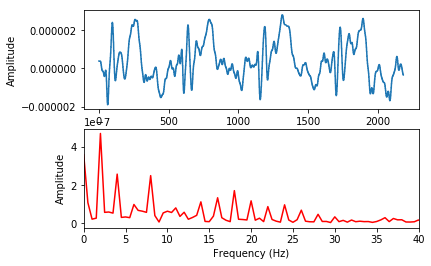

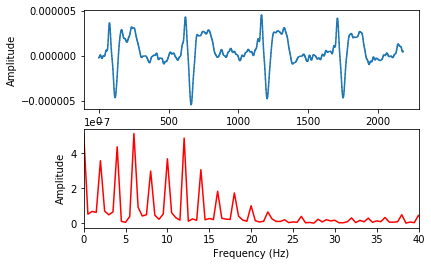

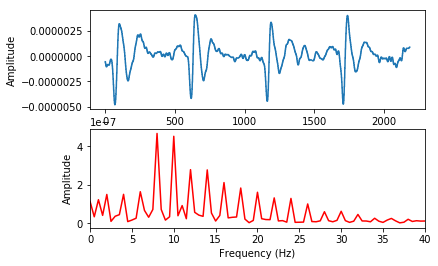

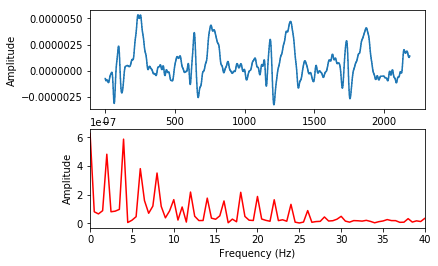

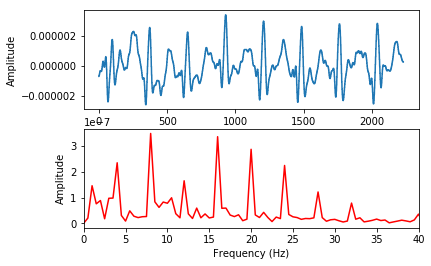

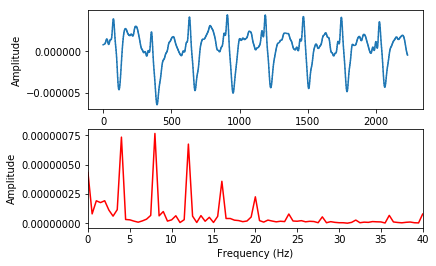

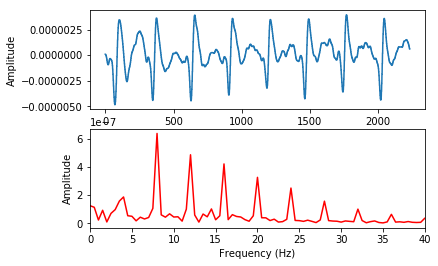

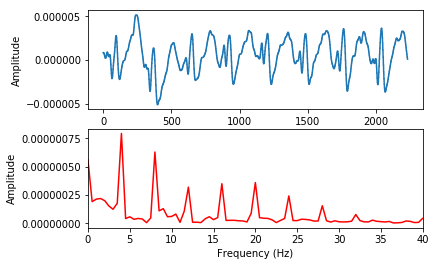

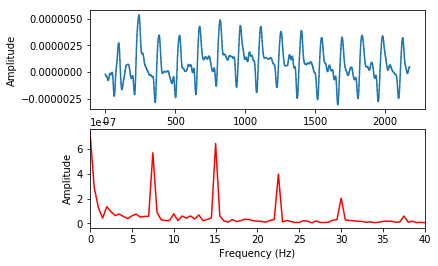

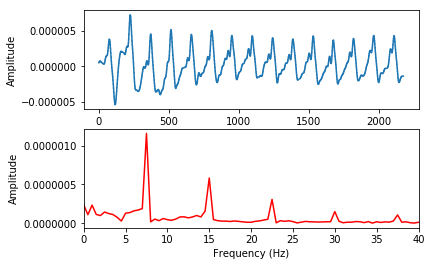

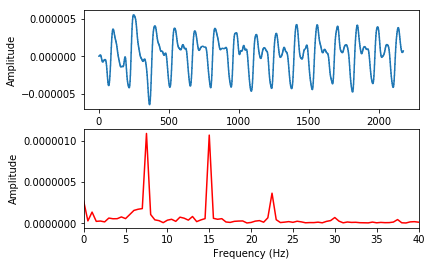

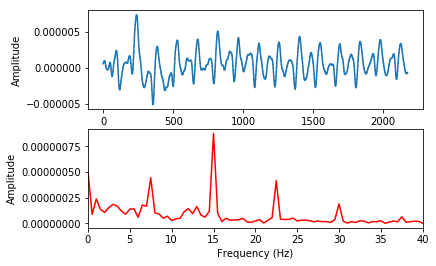

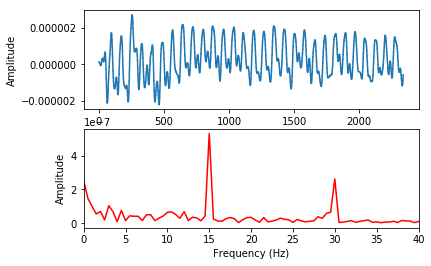

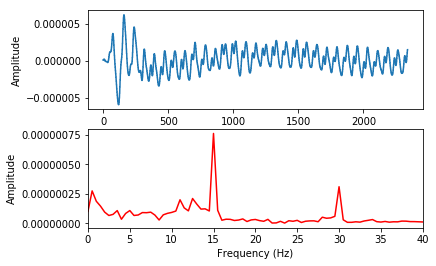

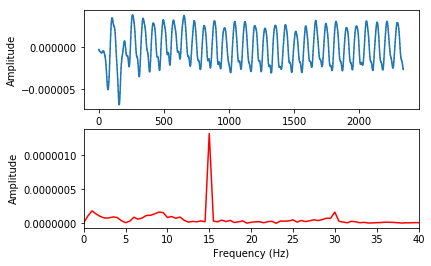

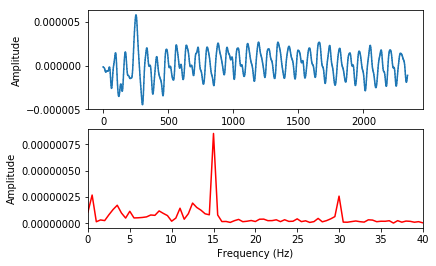

In [28]:
shiftDeg               = []
shiftRad               = []
frequency              = []
evoked_data_sparse     = []                            # the full-period data, without start and end-time
power                  = []
amplitude              = []

plot = True                                           # plot the results?
save = True                                           # save the figures?

for i in range(len(evoked_data)):                      # loop through conditions
    a, b, c, y, po, am = fourier(i, evoked_data, plot, save)
    shiftDeg.append(a)
    shiftRad.append(b)
    frequency.append(c)
    evoked_data_sparse.append(y)
    power.append(po)
    amplitude.append(am)

In [7]:
for i in range(len(evoked_data)):
    fourier(i, evoked_data, plot=False, save=False)


In [8]:
fundfreq


[1.83,
 1.83,
 1.83,
 1.83,
 3.58,
 3.58,
 3.58,
 3.58,
 6.9,
 6.9,
 6.9,
 6.9,
 12.82,
 12.82,
 12.82,
 12.82]

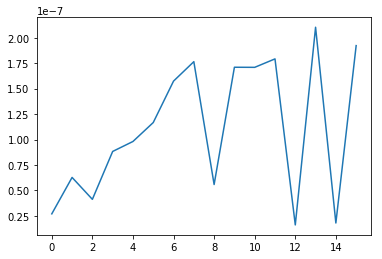

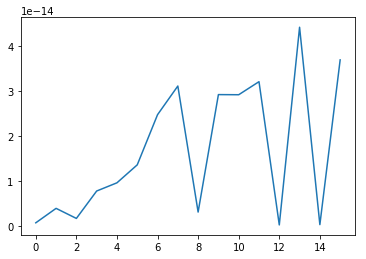

In [9]:
amplitude
plt.plot(amplitude)
plt.show()
power
plt.plot(power)
plt.show()

In [10]:
######################### HIER WEITER MACHEN MIT DIESEN ZAHLEN IM POLAR PLOT !"!!!
########## !!!!

### normalizing angles
Use the first of 4 values (full visual field stimulation) as 0 degree shift. Proceed with the other angles in relation to this value.

In [11]:
shiftRadNorm = []                      # write normalized angles (norm. to FVF stimulation) in a new list
shiftDegNorm = []
for icond in range(16):                # 16 conditions
    shiftRadNorm.append(shiftRad[icond] - shiftRad[int(floor(icond/4)*4)])
    shiftDegNorm.append(shiftDeg[icond] - shiftDeg[int(floor(icond/4)*4)])
#    print(shiftRad[int(floor(icond/4)*4)])


### converting angles to millisecons delay

lag in ms = radial shift  x  length of full cycle in ms / ( 2 * pi )

In [12]:
shiftTimeNorm = []                                                 # write ms delay in a new list
for icond in range(16):                                            # 16 conditions
    timeCycle = periodDur[icond]
    # calculate time shift
    timeShift = timeCycle * shiftRadNorm[icond] / ( 2 * np.pi )    # formula to calculate times
    shiftTimeNorm.append(timeShift)


This is the average delay (in mm) of the respective Hz response, normalized to the FVF response (which is set to 0 mm)

In [13]:
shiftTimeNorm

[0.0,
 -53.910923682303434,
 -153.26050773485264,
 -92.10151045158476,
 0.0,
 43.25310258955484,
 -35.31042244200222,
 -3.9917380102376967,
 0.0,
 10.493021847540719,
 -36.544048186643835,
 -13.015786719426632,
 0.0,
 11.389297254159892,
 -28.021413863080245,
 11.427856968194133]

This is the average delay in degree. Normalized to FVF response (which is set to 0 degree). Note, that the angle is with respect to the frequency, thus a particular angle in the 2 Hz conditions means a higher time difference than in the 4 Hz condition (and so on).

In [15]:
shiftDegNorm

[0.0,
 -35.545663966353914,
 -101.05088422078195,
 -60.726270627418515,
 0.0,
 55.81045495426433,
 -45.561835409035126,
 -5.150629690629287,
 0.0,
 26.05164044906661,
 -90.73005067028815,
 -32.3150566827144,
 0.0,
 52.56598732689181,
 -129.32960244498577,
 52.74395523781907]

### polar plot of responses
example fot this polar bar plot: https://matplotlib.org/examples/pie_and_polar_charts/polar_bar_demo.html
or a polar scatter plot: https://matplotlib.org/examples/pie_and_polar_charts/polar_scatter_demo.html

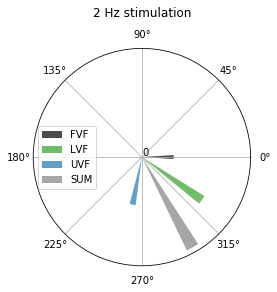

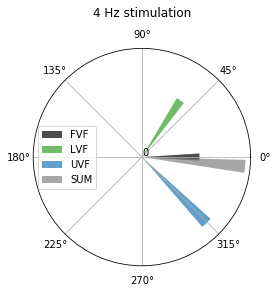

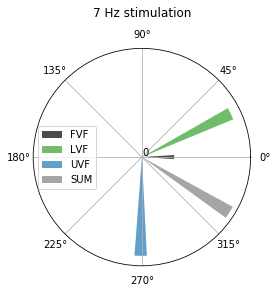

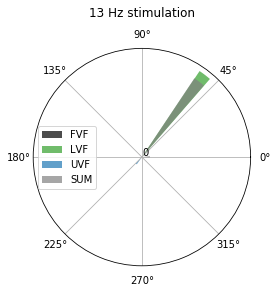

In [16]:
for i in range(4):                                          # compute for each frequency separately
    N      = 4                                              # N of conditions per frequency: here: FVF, UVF, LVF, SUM
    theta  = shiftRadNorm[i*4:i*4+4]                        # position on the circle (like position on the x-axis)


    #radii  = 1000000 * np.array(dataAbsz[i*4:i*4+4])        # height of the bars: old version, amplitude as absolute min/max value
    radii  = 1000000 * np.array(amplitude[i*4:i*4+4])        # height of the bars: new version, amplitude out of fourier transformation
    width  = np.pi / 25                                     # width of the bars
    colors = [(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]    # here black, green, blue, gray

    ax = plt.subplot(111, projection='polar')
    ax.set_title(str(stimFreq[i]) + ' Hz stimulation\n')
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    
    # Use custom colors and opacity
    for r, bar, color in zip(radii, bars, colors):
        bar.set_facecolor(color)
        bar.set_alpha(0.7)
    
    ax.legend(bars, visualFields, loc='center left')     # legend
    ax.set_yticks(np.arange(0,np.ceil(np.max(radii)),1)) # polar axis range and spacing
    # save figures
    plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_eoi_' + eoi + '_1000dpi_' + str(stimFreq[i]), dpi=1000)
    plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_eoi_' + eoi + '50dpi_' + str(stimFreq[i]), dpi=50)
    
    # show plot
    plt.show()

In [42]:
int(np.ceil(np.max(theta)))

2

In [43]:
np.arange?

## cross-correlation as a measure of phase

to do ? or is a FFT sufficient ?


# similarity between curves

## sum of squares (here: mean squared error)
For each x value, compute delta_yi = y1,i - y2,i and accumulate delta_yi2. This metric is the basis for a least square optimization, where the goal is to minimize the sum of the squares of the errors. This is a widely used approach because oftentimes it is fairly easy to implement.
https://stackoverflow.com/questions/6723157/how-to-compare-two-curves-arrays-of-points

MSE = 1 / n * sum ( ( Y(pred) - Y(obs) ) ^ 2 )

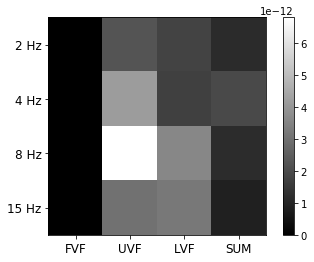

[[0.00000000e+00 2.25433759e-12 1.79730924e-12 1.14866999e-12]
 [0.00000000e+00 4.16393065e-12 1.70679909e-12 1.95497413e-12]
 [0.00000000e+00 6.81401720e-12 3.61326612e-12 1.20632204e-12]
 [0.00000000e+00 3.00912637e-12 3.20857200e-12 8.86232745e-13]]


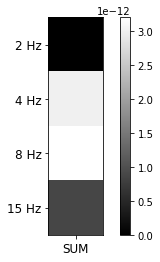

In [87]:
Ncond = len(evoked_data_sparse)                              # total # conditions
MSE = zeros((4,4))                                # empty array to store all comparisons
for i1, i1i in zip( [0,4,8,12] , range(4) ):           # go in 1st dimension
    for i2, i2i in zip( range(i1,i1+4), range(4) ):  # go in 2nd dimension
        SE = []
        Ntp   = len(evoked_data_sparse[i1])                  # total # time points
        
        for j in range(Ntp):                                 # go through the data
            Yp = evoked_data_sparse[i1][j]
            Yo = evoked_data_sparse[i2][j]
            SE.append( ( ( Yp - Yo ) ** 2 ) )
            
        MSE[i1i][i2i] = 1 / Ntp * sum(SE)

fig = plt.imshow(MSE, cmap='gray', interpolation='nearest')  # plot
plt.colorbar()
xlabels = ['FVF','UVF','LVF','SUM']
ylabels = ['2 Hz','4 Hz','8 Hz','15 Hz']
plt.xticks(range(len(xlabels)), xlabels, fontsize=12)
plt.yticks(range(len(ylabels)), ylabels, fontsize=12)
plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSE_eoi_' + eoi + '_50dpi',   dpi=50)
plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSE_eoi_' + eoi + '_1000dpi', dpi=1000)
plt.show()

print(MSE)

# only for the SUM condition compared to FVF
sumMSE = MSE[:][-1] # In your specific case you got a 1D array, so you need to add a dimension with np.expand_dims()
sumMSE = np.asarray(sumMSE)
sumMSE = np.expand_dims(sumMSE, axis=0)
sumMSE = np.transpose(sumMSE)

fig = plt.imshow(sumMSE, cmap='gray', interpolation='nearest')  # plot
plt.colorbar()
xlabels = ['SUM']
ylabels = ['2 Hz','4 Hz','8 Hz','15 Hz']
plt.xticks(range(len(xlabels)), xlabels, fontsize=12)
plt.yticks(range(len(ylabels)), ylabels, fontsize=12)
plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSEsum_eoi_' + eoi + '50dpi',   dpi=50)
plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSEsum_eoi_' + eoi + '1000dpi', dpi=1000)
plt.show()

In [20]:
np.asarray?

## maximum deviation
Find the abs_delta_yi = |y1,i - y2,i| that maximizes the |y1,i - y2,i| for all x values. This metric is the basis for a lot of the implementations of the functions in the math library, where the goal is to minimize the maximum error. These math library implementations are approximations of the true function. As a consumer of such an approximation, I typically care more about the worst thing that the approximation is going to do to my application than I care about how that approximation is going to behave on average. https://stackoverflow.com/questions/6723157/how-to-compare-two-curves-arrays-of-points

## weighted least squares
'In my research I compared two curves (data vs model) and I used the  weighted least squares (WLS)
For the WLS method it was defined as the sum of the absolute differences between observed and expected values, divided by the observed values (Lika et al. 2011).'
https://www.researchgate.net/post/Is_there_any_statistical_method_to_compare_two_curves_in_a_graph_eg_quantifying_how_similar_different_they_are

WLS = 1 / n * sum ( | 1 - ( expected value / observed value) | )

Ncond = len(evoked_data)                                     # total # conditions
Ntp   = len(evoked_data[0])                                  # total # time points
WLS2 = zeros( (Ncond, Ncond) )                             # empty array to store all comparisons
for i1 in range(Ncond):                                      # go in 1st dimension
    for i2 in range(Ncond):                                  # go in 2nd dimension
        LS=[]
        for j in range(Ntp):                                 # go through the data
            ev = evoked_data[i1][j]
            ov = evoked_data[i2][j]
            LS.append( abs( ( 1 - ev / ov ) ) )
        WLS2[i1][i2] = 1 / Ntp * sum(LS)
fig = plt.imshow(WLS2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()